In [2]:
import wandb
import numpy as np
import os
import random
import glob
import pandas as pd
import time
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import importlib
from common import common
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, VotingClassifier
from sklearn.datasets import fetch_covtype
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.io import arff
from sklearn.datasets import fetch_openml
from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [3]:
wandb.login()

wandb: Currently logged in as: brinashong. Use `wandb login --relogin` to force relogin


True

In [4]:
# Reload common module
importlib.reload(common)

<module 'common.common' from '/home/brina/nus-mcomp/sem2/cs5344-big-data-analytics-technology/CS5344_Project.git/sy/work/common/common.py'>

In [5]:
# Shared variables
OUTPUT_FOLDER = 'csv_files'
FEATURE_FOLDER = 'features'

In [18]:
# project name should correspond to dataset below
project_name = "covertype"
# project_name = "kdd"
# project_name = "cicids"
# project_name = "thyroid"
# project_name = "unsw"
# project_name = "customer"
# project_name = "satellite"
# project_name = "drug"
# project_name = "mba"

In [19]:
if project_name == "covertype":
    %run datasets/covertype.ipynb
    all_df, main_labels, config = get_processed_covtype_df()
elif project_name == "kdd":
    %run datasets/kdd.ipynb
    all_df, main_labels, config = get_processed_kdd_df()
elif project_name == "cicids":
    %run datasets/cicids.ipynb
    all_df, main_labels, config = get_processed_cicids_df()
elif project_name == "thyroid":
    %run datasets/thyroid.ipynb
    all_df, main_labels, config = get_processed_thyroid_df()
elif project_name == "unsw":
    %run datasets/unsw.ipynb
    all_df, main_labels, config = get_processed_unsw_df()
elif project_name == "customer":
    %run datasets/customer.ipynb
    all_df, main_labels, config = get_processed_customer_df()
elif project_name == "satellite":
    %run datasets/satellite.ipynb
    all_df, main_labels, config = get_processed_satellite_df()
elif project_name == "drug":
    %run datasets/drug.ipynb
    all_df, main_labels, config = get_processed_drug_df()
else:
    %run datasets/mba.ipynb
    all_df, main_labels, config = get_processed_mba_df()

Normal class:  0    2
dtype: int32


In [20]:
# Should already be one hot encoded and label encoded

TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [21]:
all_df.shape

(581012, 55)

In [22]:
# Create a folder to save the CSVs
common.remove_files_from_directory(OUTPUT_FOLDER)
common.remove_files_from_directory(FEATURE_FOLDER)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(FEATURE_FOLDER, exist_ok=True)

All files in csv_files have been removed.
All files in features have been removed.


In [23]:
# Save all data as csv
all_df.to_csv('all_data.csv' ,index = False)

In [24]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and test sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(464809, 54) (116203, 54) (464809,) (116203,)


In [25]:
# Concatenate X_train and y_train along the columns (axis=1)
X_y_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_y_train_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
519924,3289.0,22.0,19.0,240.0,93.0,1708.0,205.0,196.0,122.0,2598.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
318451,2963.0,21.0,18.0,134.0,27.0,1243.0,206.0,200.0,127.0,1140.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
22325,3037.0,185.0,9.0,127.0,10.0,6462.0,222.0,246.0,158.0,3037.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
449376,3113.0,203.0,13.0,190.0,22.0,2125.0,213.0,251.0,171.0,730.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
482753,3128.0,346.0,9.0,120.0,36.0,552.0,203.0,226.0,161.0,924.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [26]:
# Fit and transform the numeric columns
scaler, X_train_scaled_df = common.standardise(X_train_df, NUMERICAL_COLUMNS)
# print('X_train_scaled_df', X_train_scaled_df)

# Use the same scaler to transform X_test
scaler, X_test_scaled_df = common.standardise(X_test_df, NUMERICAL_COLUMNS, scaler=scaler)
# print('X_test_scaled_df', X_test_scaled_df)

In [27]:
X_test_scaled_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
250728,1.399198,0.450259,1.723365,2.149461,1.332172,0.937856,-0.753243,1.450972,0.980052,0.219004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
246788,-0.810613,-0.237831,-0.948062,-0.269777,-0.778592,-0.813239,0.704291,0.641599,-0.144387,-0.806331,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
407714,-1.381808,-1.176136,-0.680920,-0.321550,-0.366736,-0.893388,0.143701,-0.066603,-0.013638,0.158646,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25713,-0.482175,-0.774005,-0.146634,0.695094,-0.126486,0.559553,0.779036,-0.471289,-0.850431,3.393092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21820,-1.535316,-0.639962,-1.215205,-0.702792,-0.641307,-0.806827,0.554800,0.388670,-0.092088,2.265148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
seconds = time.time()

benign = 2359289
abnormal_type_counts = all_df[TARGET_COLUMN].value_counts()
abnormal_type_dict = abnormal_type_counts.to_dict()
print('abnormal_type_dict', abnormal_type_dict)
target_index = all_df.columns.get_loc(TARGET_COLUMN)
benign_ratio = 3  # Adjust this ratio as needed
min_benign_samples = 50  # Ensure at least 50 benign samples are always included

# Linear method
for label, name in TARGET_DICT.items():
    if label == NORMAL_TARGET:
        continue  # Skip the normal target
    
    common.create_dataset_for_label(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)
    
# Parallel execution to create the anomaly datasets for each anomaly class
# def create_dataset(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels):
#     return common.create_dataset_for_label(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)

# # Using Joblib to parallelize the dataset creation
# results = Parallel(n_jobs=-1)(
#     delayed(create_dataset)(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)
#     for label, name in TARGET_DICT.items() if label != NORMAL_TARGET
# )

print("All datasets created successfully!")
print("Total operation time: =", time.time() - seconds, "seconds")

abnormal_type_dict {2: 283301, 1: 211840, 3: 35754, 7: 20510, 6: 17367, 5: 9493, 4: 2747}
Spruce-Fir.csv created with 495141 rows. (283301 benign and 211840 abnormal rows)
PonderosaPine.csv created with 143016 rows. (107262 benign and 35754 abnormal rows)
CottonwoodWillow.csv created with 10988 rows. (8241 benign and 2747 abnormal rows)
Aspen.csv created with 37972 rows. (28479 benign and 9493 abnormal rows)
DouglasFir.csv created with 69468 rows. (52101 benign and 17367 abnormal rows)
Krummholz.csv created with 82040 rows. (61530 benign and 20510 abnormal rows)
All datasets created successfully!
Total operation time: = 5.304694652557373 seconds


In [29]:
len(main_labels)

55

csv_files ['Krummholz.csv', 'CottonwoodWillow.csv', 'Spruce-Fir.csv', 'Aspen.csv', 'DouglasFir.csv', 'PonderosaPine.csv']
Processing CSV file: Krummholz.csv
Krummholz importance list:
Krummholz 
                                     importance
Features                                      
Elevation                             0.796165
Horizontal_Distance_To_Roadways       0.043161
Horizontal_Distance_To_Fire_Points    0.023963
Horizontal_Distance_To_Hydrology      0.021354
Vertical_Distance_To_Hydrology        0.008739
Wilderness_Area_1                     0.008322
Hillshade_Noon                        0.007198
Aspect                                0.004514
Hillshade_9am                         0.004440
Wilderness_Area_2                     0.002920
Hillshade_3pm                         0.002729
Wilderness_Area_0                     0.002119
Slope                                 0.001834
Soil_Type_3                           0.000499
Wilderness_Area_3                     0.000000
Soil_

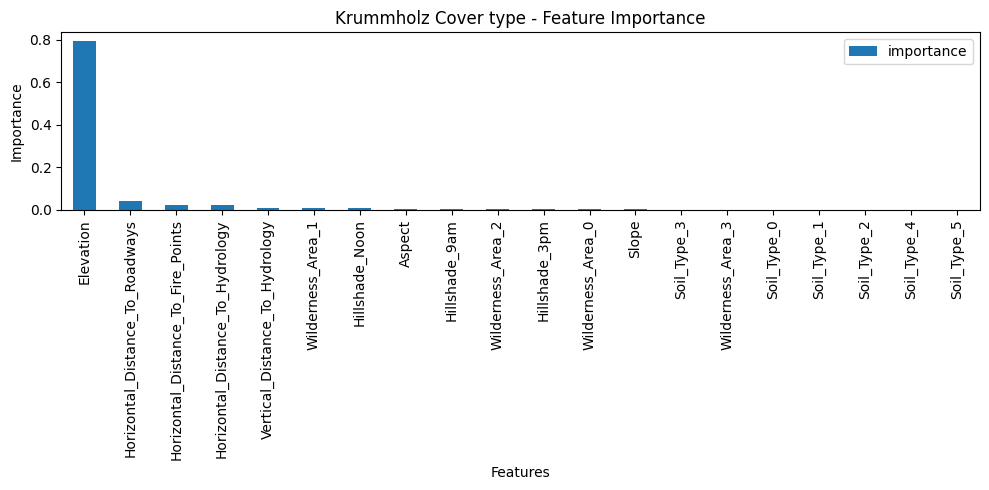

-----------------------------------------------------------------------------------------------




Processing CSV file: CottonwoodWillow.csv
CottonwoodWillow importance list:
CottonwoodWillow 
                                     importance
Features                                      
Elevation                             0.974188
Soil_Type_4                           0.004398
Horizontal_Distance_To_Fire_Points    0.003402
Wilderness_Area_3                     0.003194
Wilderness_Area_2                     0.002754
Horizontal_Distance_To_Roadways       0.002403
Soil_Type_5                           0.001664
Hillshade_9am                         0.001584
Horizontal_Distance_To_Hydrology      0.001355
Vertical_Distance_To_Hydrology        0.000703
Hillshade_3pm                         0.000675
Aspect                                0.000634
Hillshade_Noon                        0.000564
Slope                                 0.000365
Soil_Type_0                           0.000174
Soil_T

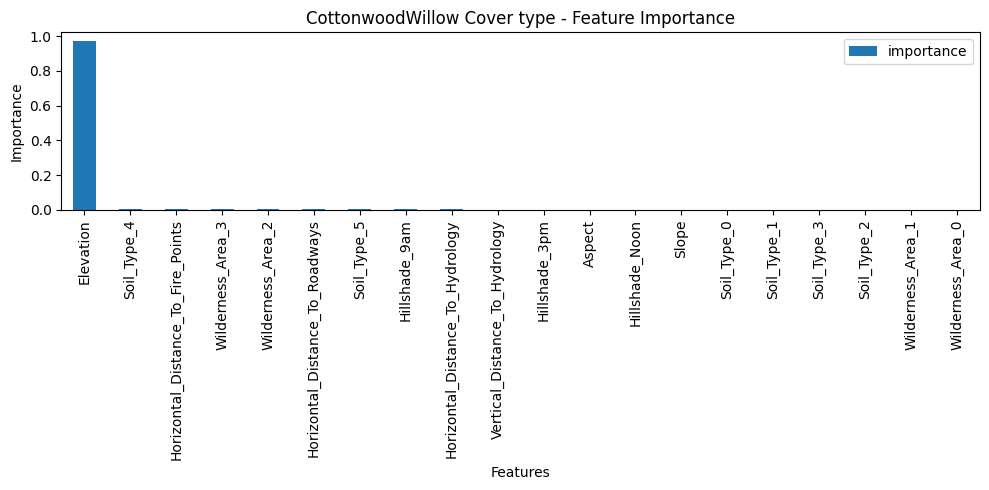

-----------------------------------------------------------------------------------------------




Processing CSV file: Spruce-Fir.csv
Spruce-Fir importance list:
Spruce-Fir 
                                       importance
Features                                        
Elevation                           3.278595e-01
Horizontal_Distance_To_Fire_Points  1.577120e-01
Horizontal_Distance_To_Roadways     1.574300e-01
Horizontal_Distance_To_Hydrology    6.806803e-02
Vertical_Distance_To_Hydrology      4.699788e-02
Hillshade_Noon                      3.909479e-02
Hillshade_9am                       2.817367e-02
Aspect                              2.762956e-02
Hillshade_3pm                       2.191857e-02
Slope                               1.631059e-02
Wilderness_Area_2                   1.046425e-02
Wilderness_Area_0                   8.030734e-03
Wilderness_Area_1                   4.921842e-03
Soil_Type_3                         1.884758e-04
Soil_Type_1                         1.3

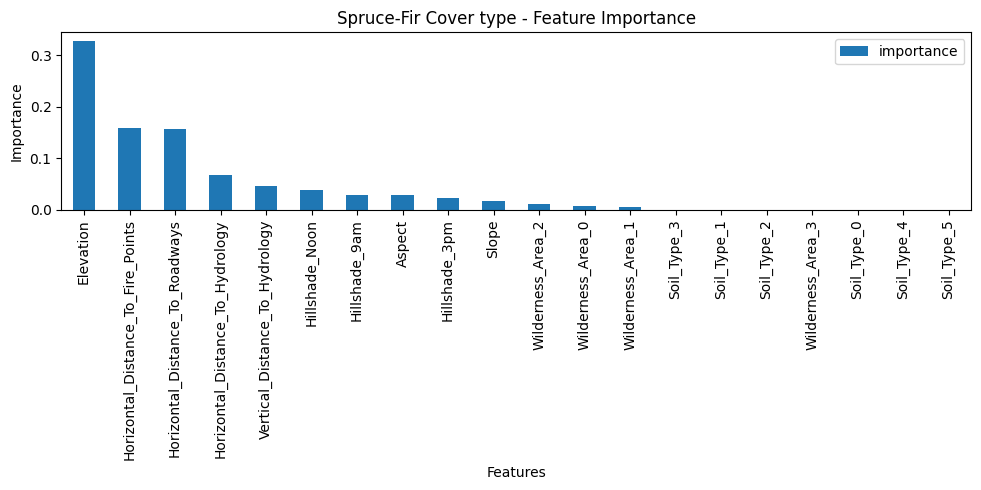

-----------------------------------------------------------------------------------------------




Processing CSV file: Aspen.csv
Aspen importance list:
Aspen 
                                     importance
Features                                      
Elevation                             0.299760
Horizontal_Distance_To_Roadways       0.177274
Horizontal_Distance_To_Fire_Points    0.131472
Hillshade_Noon                        0.048511
Horizontal_Distance_To_Hydrology      0.043827
Hillshade_9am                         0.042062
Wilderness_Area_2                     0.041985
Vertical_Distance_To_Hydrology        0.034798
Hillshade_3pm                         0.026562
Aspect                                0.025906
Slope                                 0.021581
Soil_Type_3                           0.006158
Soil_Type_1                           0.004524
Soil_Type_2                           0.003198
Wilderness_Area_0                     0.001338
Wilderness_Area_3                     0

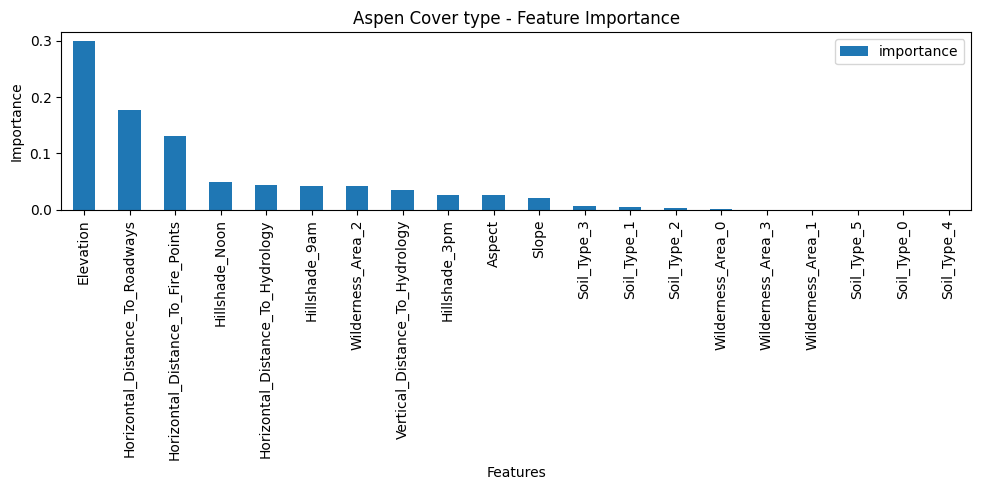

-----------------------------------------------------------------------------------------------




Processing CSV file: DouglasFir.csv
DouglasFir importance list:
DouglasFir 
                                       importance
Features                                        
Elevation                           6.874738e-01
Wilderness_Area_0                   5.405510e-02
Wilderness_Area_2                   4.806981e-02
Horizontal_Distance_To_Roadways     4.243601e-02
Horizontal_Distance_To_Fire_Points  4.012154e-02
Aspect                              2.306575e-02
Vertical_Distance_To_Hydrology      1.733841e-02
Horizontal_Distance_To_Hydrology    1.156862e-02
Hillshade_Noon                      8.956790e-03
Hillshade_9am                       8.750798e-03
Hillshade_3pm                       8.479403e-03
Slope                               4.908987e-03
Soil_Type_2                         2.481116e-03
Wilderness_Area_3                   2.479457e-03
Soil_Type_3                         2.1

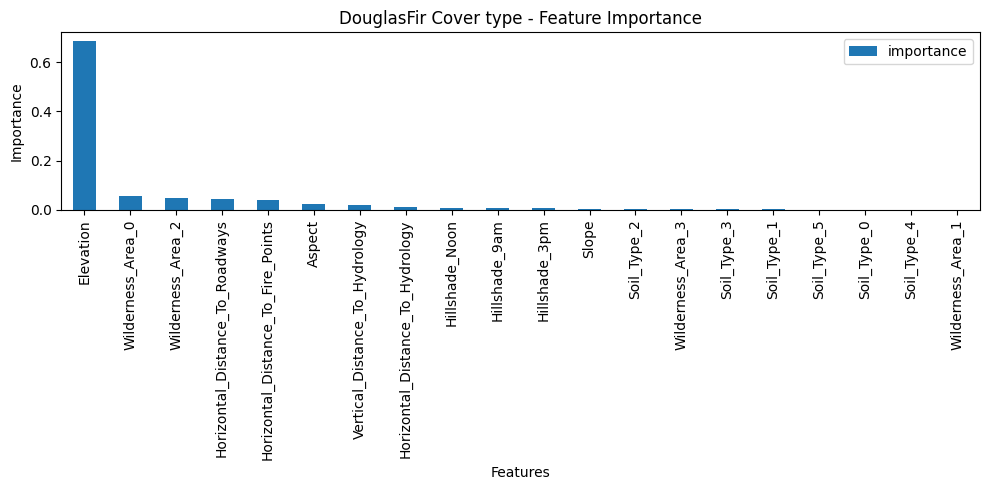

-----------------------------------------------------------------------------------------------




Processing CSV file: PonderosaPine.csv
PonderosaPine importance list:
PonderosaPine 
                                     importance
Features                                      
Elevation                             0.665878
Wilderness_Area_0                     0.092946
Soil_Type_1                           0.050592
Soil_Type_3                           0.049399
Horizontal_Distance_To_Roadways       0.032677
Horizontal_Distance_To_Fire_Points    0.028044
Horizontal_Distance_To_Hydrology      0.014477
Vertical_Distance_To_Hydrology        0.009190
Hillshade_Noon                        0.008549
Hillshade_9am                         0.007132
Aspect                                0.007111
Hillshade_3pm                         0.004990
Slope                                 0.004376
Wilderness_Area_3                     0.002381
Wilderness_Area_2                     0.002246
Soil_Type_2    

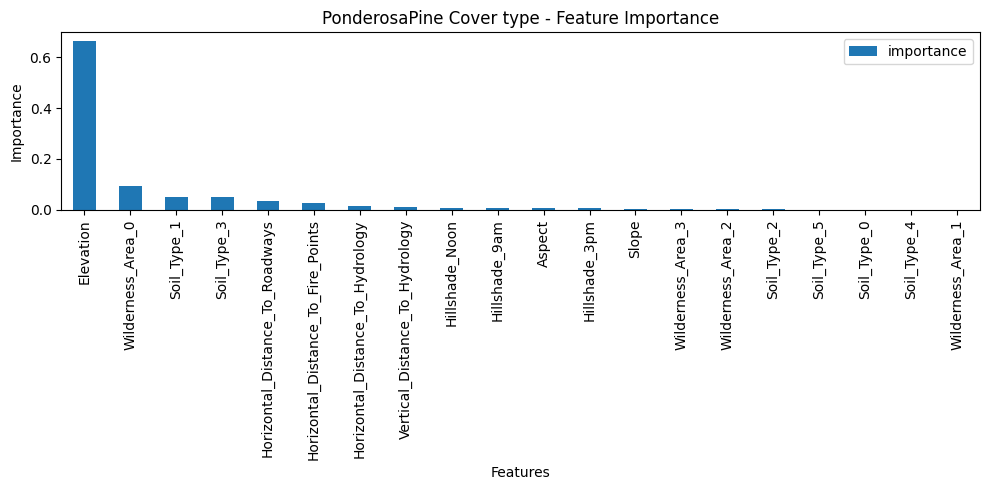

-----------------------------------------------------------------------------------------------




feature_importances: {'Krummholz': ['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology'], 'CottonwoodWillow': ['Elevation', 'Soil_Type_4', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_3', 'Wilderness_Area_2'], 'Spruce-Fir': ['Elevation', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology'], 'Aspen': ['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Hillshade_Noon', 'Horizontal_Distance_To_Hydrology'], 'DouglasFir': ['Elevation', 'Wilderness_Area_0', 'Wilderness_Area_2', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points'], 'PonderosaPine': ['Elevation', 'Wilderness_Area_0', 'Soil_Type_1', 'Soil_Type_3', 'Horizontal_Distance_To_Road

In [30]:
seconds = time.time()

# CSV files names:
csv_files=os.listdir(OUTPUT_FOLDER)
print('csv_files',csv_files)

feature_importances = {}
KNNs = {}

# Linear way
for csv in csv_files:
    label, important_features, knn, impor_bars = common.process_csv_with_args(csv, 
        main_labels=main_labels, 
        target_column=TARGET_COLUMN, 
        normal_target=NORMAL_TARGET, 
        numerical_columns=NUMERICAL_COLUMNS, 
        output_folder=OUTPUT_FOLDER,
        scaler=scaler)
    feature_importances[label] = important_features
    KNNs[label] = knn
    common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

# process_csv_with_args = partial(
#         common.process_csv, 
#         main_labels=main_labels, 
#         target_column=TARGET_COLUMN, 
#         normal_target=NORMAL_TARGET, 
#         numerical_columns=NUMERICAL_COLUMNS, 
#         output_folder=OUTPUT_FOLDER,
#         scaler=scaler 
#     )

# with ProcessPoolExecutor() as executor:
#         results = list(executor.map(process_csv_with_args, csv_files))

# # Collect results from the futures
# for label, important_features, svm, impor_bars in results:
#     feature_importances[label] = important_features
#     SVMs[label] = svm

#     # Show feature importance
#     common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
#     print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances:', feature_importances)
print("Total operation time: =", time.time() - seconds, "seconds")

In [31]:
seconds = time.time()

# Define the model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_df, y_train_df)

# # Define the parameter grid to search
# param_distributions = {
#     'n_estimators': [100, 200, 300, 400, 500],               # Number of trees
#     'max_depth': [None, 10, 20, 30, 40, 50],                 # Tree depth
#     'min_samples_split': [2, 5, 10],                         # Minimum samples to split a node
#     'min_samples_leaf': [1, 2, 4],                           # Minimum samples at a leaf
#     'max_features': ['auto', 'sqrt', 'log2'],                # Number of features to consider at each split
#     'bootstrap': [True, False]                               # Use bootstrap samples or not
# }

# # Perform random search with cross-validation
# random_search = RandomizedSearchCV(estimator=rf, 
#                                    param_distributions=param_distributions, 
#                                    n_iter=100,  # Number of parameter settings sampled
#                                    cv=3,        # 3-fold cross-validation
#                                    random_state=42, 
#                                    n_jobs=-1)   # Use all cores

# Fit the model
# random_search.fit(X_train_df, y_train_df)

# Best parameters found
# print("Best parameters found: ", random_search.best_params_)
# print("Best score: ", random_search.best_score_)

# Predict classes for the test set
test_predictions = rf.predict(X_test_df)
print('test_predictions', test_predictions)

print("Total operation time: = ", time.time() - seconds, "seconds")

test_predictions [1 2 2 ... 2 2 7]
Total operation time: =  11.468710660934448 seconds


Multiclass Classification Evaluation


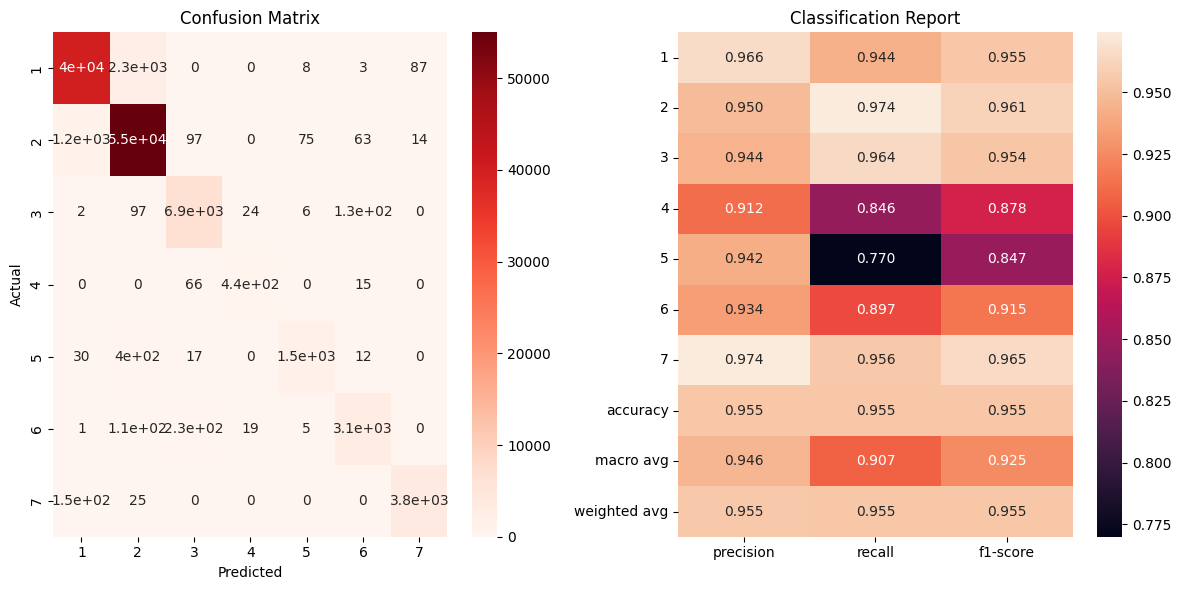

Accuracy: 0.9551646687262807


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.95516
f1-score_avg,0.95492
precision_avg,0.95527
recall_avg,0.95516


In [32]:
pn = "pipeline-" + project_name
wandb.init(project=pn, name="classification")
common.evaluate(y_test_df, test_predictions, heading='Multiclass Classification Evaluation')
wandb.finish()

In [34]:
knn_predictions = []
seconds = time.time()
LOWER_THRESHOLD = 0.5
UPPER_THRESHOLD = 0.9
improve_cnt = 0
deprove_cnt = 0

def predict_knn(predicted_label, test_instance_df):
    selected_features = feature_importances[predicted_label]
    knn_model = KNNs[predicted_label]
    # Select features for the KNN
    test_instance_selected_df = test_instance_df[selected_features]
    knn_prediction = knn_model.predict_proba(test_instance_selected_df)
    # print(knn_prediction)
    normal_class_prob = knn_prediction[:, 1]
    abnormal_class_prob = knn_prediction[:, 0]
    
    return (abnormal_class_prob, normal_class_prob)

for i in range(len(X_test_scaled_df)):
    test_instance_df = X_test_scaled_df.iloc[i].to_frame().T
    
    if test_predictions[i] == NORMAL_TARGET:
        # class_probabilities = {}
        
        # # Test the normal data point with all anomaly models
        # for class_label, svm_model in SVMs.items():
        #     # Select features for the SVM
        #     selected_features = feature_importances[class_label]
        #     test_instance_selected_df = test_instance_df[selected_features]
        #     proba = svm_model.predict_proba(test_instance_selected_df)
            
        #     # We take the probability of class 0 (anomaly class)
        #     anomaly_proba = proba[0][0]
        #     class_probabilities[class_label] = anomaly_proba

        # # Get the class with the highest probability
        # most_probable_class = max(class_probabilities, key=class_probabilities.get)
        
        # # If the highest probability class has a probability greater than a threshold (e.g., 0.5), classify it as anomaly
        # if class_probabilities[most_probable_class] > 0.5:
        #     svm_predictions.append((0, INV_TARGET_DICT[most_probable_class], y_test_df.iloc[i]))
        # else:
            # Otherwise, classify it as normal

        # New method
        knn_predictions.append((NORMAL_TARGET, y_test_df.iloc[i]))
        # Old method
        # knn_predictions.append((1, NORMAL_TARGET, y_test_df.iloc[i]))
    else:
        # New method
        predicted_label = TARGET_DICT[test_predictions[i]]
        abnormal_class_prob, normal_class_prob = predict_knn(predicted_label, test_instance_df)
        max_prob = abnormal_class_prob if abnormal_class_prob > normal_class_prob else normal_class_prob
        final_class_1 = INV_TARGET_DICT[predicted_label] if abnormal_class_prob > normal_class_prob else NORMAL_TARGET
        final_class_2 = final_class_1

        if normal_class_prob > LOWER_THRESHOLD and normal_class_prob < UPPER_THRESHOLD:
            for key, knn in KNNs.items():
                if key != predicted_label:
                    sub_abnormal_class_prob, sub_normal_class_prob = predict_knn(key, test_instance_df)
                    if sub_abnormal_class_prob > sub_normal_class_prob and sub_abnormal_class_prob > max_prob:
                        max_prob = sub_abnormal_class_prob
                        final_class_2 = INV_TARGET_DICT[key]
                        # print('sub abnormal', sub_abnormal_class_prob, 'sub normal', sub_normal_class_prob)

        status = ''
        if final_class_1 != final_class_2 and final_class_2 == y_test_df.iloc[i]:
            improve_cnt += 1
            status = 'improve'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, normal_class_prob, max_prob)
        if final_class_1 != final_class_2 and final_class_1 == y_test_df.iloc[i]:
            deprove_cnt += 1
            status = 'deprove'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, normal_class_prob, max_prob)
        # print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, abnormal_class_prob, normal_class_prob)
        knn_predictions.append((final_class_2, y_test_df.iloc[i]))

        # Old method
        # predicted_label = TARGET_DICT[test_predictions[i]]
        # selected_features = feature_importances[predicted_label]
        # knn_model = KNNs[predicted_label]
        # test_instance_selected_df = test_instance_df[selected_features]
        # knn_prediction = knn_model.predict(test_instance_selected_df)
        # print(knn_prediction)
        # knn_predictions.append((knn_prediction[0], INV_TARGET_DICT[predicted_label], y_test_df.iloc[i]))

print('improve_cnt', improve_cnt, 'deprove_cnt', deprove_cnt)
print("Total operation time: = ", time.time() - seconds, "seconds")

final_class1 2 final_class2 6 actual 2 deprove [0.53355019] [0.85913537]
final_class1 2 final_class2 3 actual 2 deprove [0.65699845] [1.]
final_class1 2 final_class2 5 actual 5 improve [0.60305178] [1.]
final_class1 2 final_class2 6 actual 6 improve [0.7768897] [1.]
final_class1 2 final_class2 6 actual 6 improve [0.64402477] [1.]
final_class1 2 final_class2 7 actual 7 improve [0.86856258] [1.]
final_class1 2 final_class2 5 actual 5 improve [0.50870567] [1.]
final_class1 2 final_class2 4 actual 2 deprove [0.58335188] [1.]
final_class1 2 final_class2 6 actual 6 improve [0.65932758] [1.]
final_class1 2 final_class2 5 actual 5 improve [0.62469633] [1.]
final_class1 2 final_class2 5 actual 5 improve [0.80405324] [1.]
final_class1 2 final_class2 5 actual 5 improve [0.87117443] [1.]
final_class1 2 final_class2 5 actual 5 improve [0.53159096] [1.]
final_class1 2 final_class2 3 actual 2 deprove [0.70893647] [0.75494093]
final_class1 2 final_class2 3 actual 3 improve [0.62832277] [1.]
final_clas

KNN Evaluation (overall)


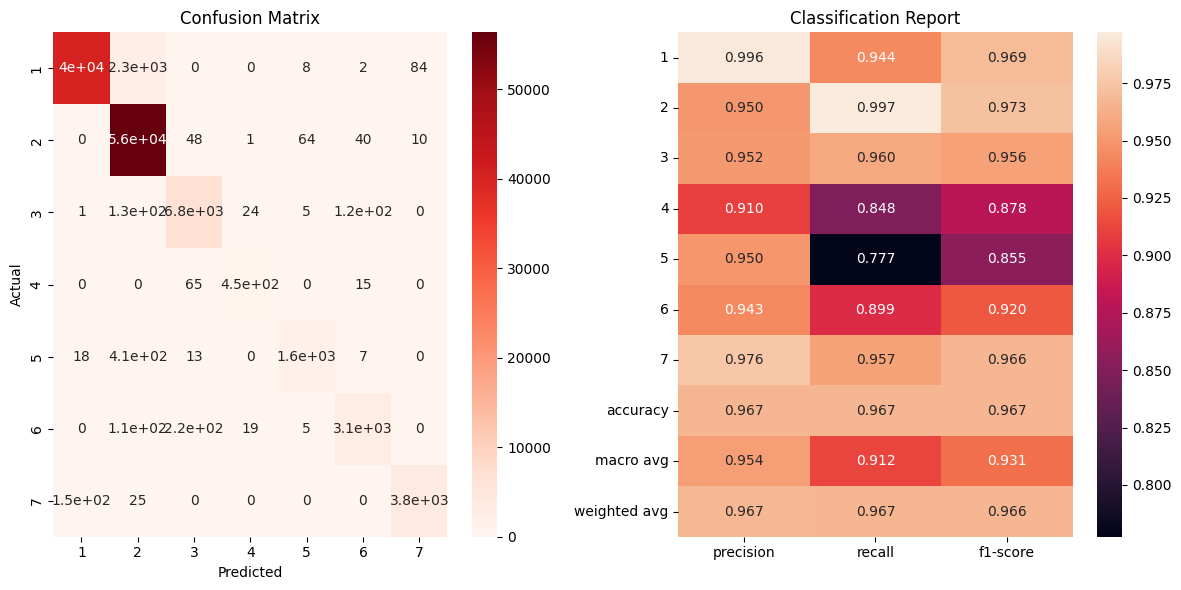

Accuracy: 0.9665154944364603


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.96652
f1-score_avg,0.96625
precision_avg,0.96739
recall_avg,0.96652


In [35]:
# Evaluate KNN on all test data
pn = "pipeline-" + project_name
wandb.init(project=pn, name="final")

# Modify the list and extract the second element in one step
final_knn_predictions = [t[0] for t in knn_predictions] # New
# final_knn_predictions = [(lambda t: (t[0], NORMAL_TARGET, t[2]) if t[0] == 1 else t)(t)[1] for t in knn_predictions] # Old
final_knn_predictions_df = pd.DataFrame(final_knn_predictions, columns=[TARGET_COLUMN])
common.evaluate(y_test_df, final_knn_predictions_df, heading='KNN Evaluation (overall)')
wandb.finish()